In [ ]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.classifier import StackingCVClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
#Loading Dataset
data = pd.read_csv('C:/Users/GVJai/Desktop/Project/kidney_stone_prediction/kindey stone urine analysis.csv')

#Displaying the first few rows of the dataset
print(data.head())

   gravity    ph  osmo  cond  urea  calc  target
0    1.021  4.91   725  14.0   443  2.45       0
1    1.017  5.74   577  20.0   296  4.49       0
2    1.008  7.20   321  14.9   101  2.36       0
3    1.011  5.51   408  12.6   224  2.15       0
4    1.005  6.52   187   7.5    91  1.16       0


In [4]:
#checking missing values
print(data.isnull().sum())

gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64


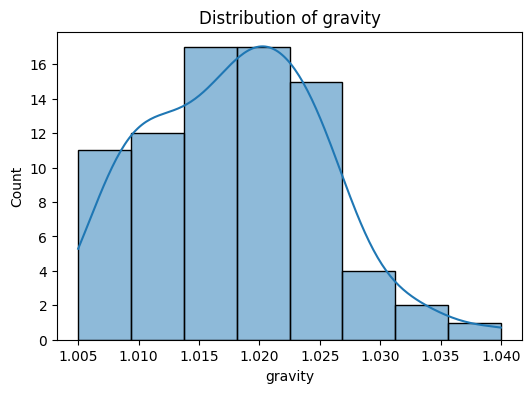

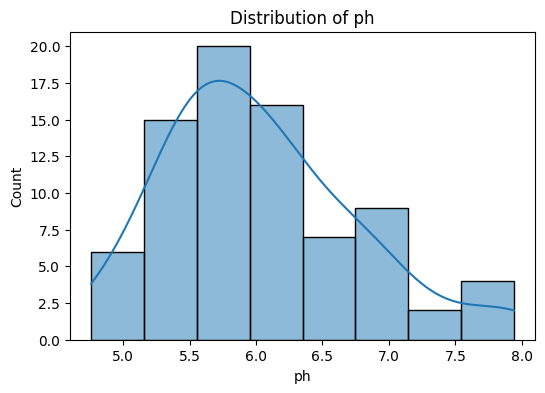

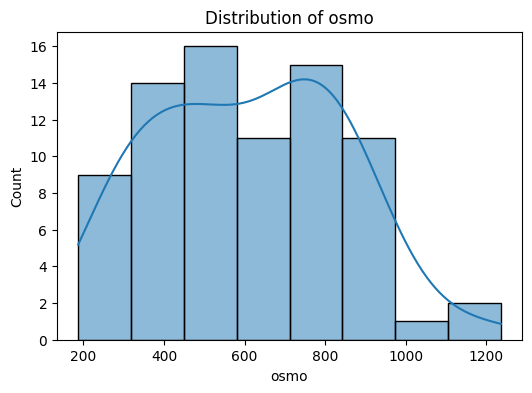

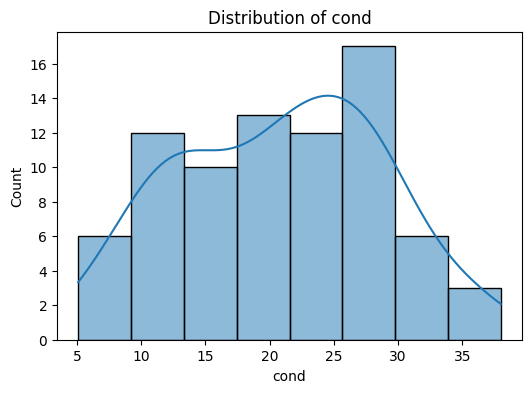

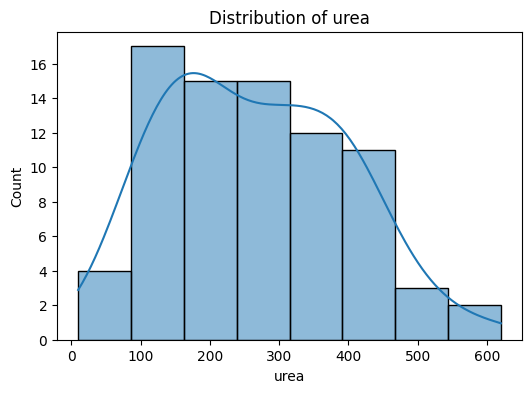

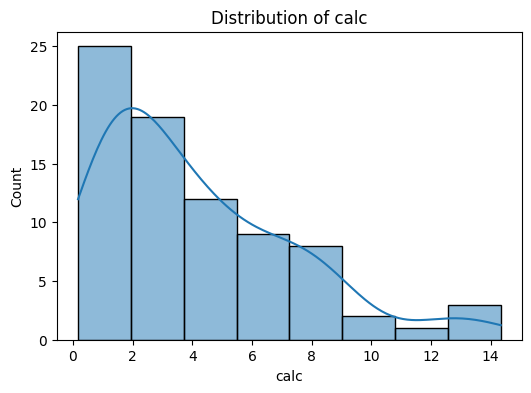

In [ ]:
#Univariate Analysis of Features
for col in data.columns[:-1]:  # Excluding the target column
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


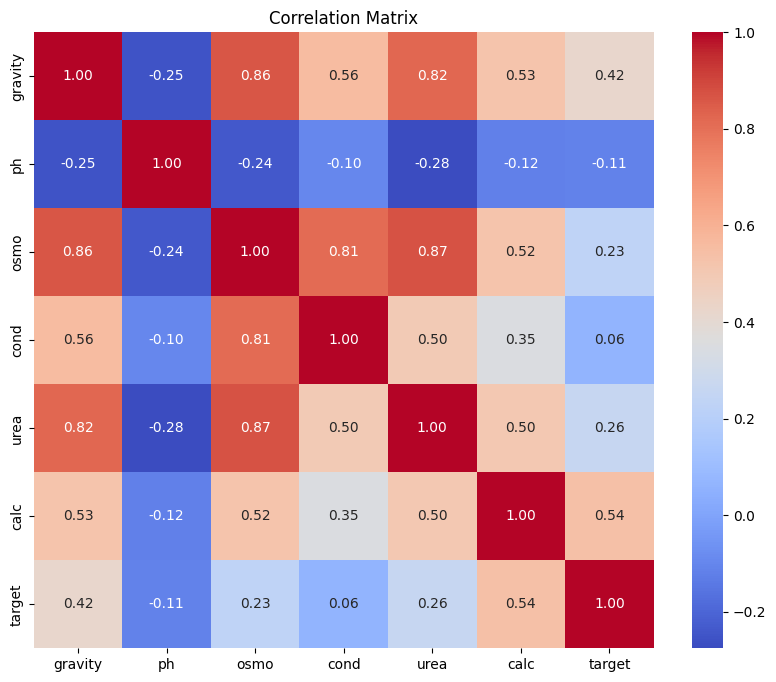

In [26]:
#correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

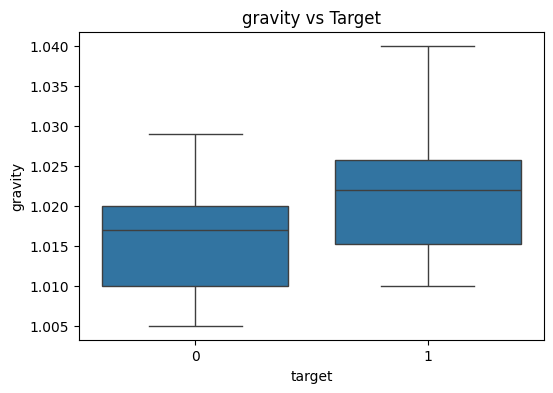

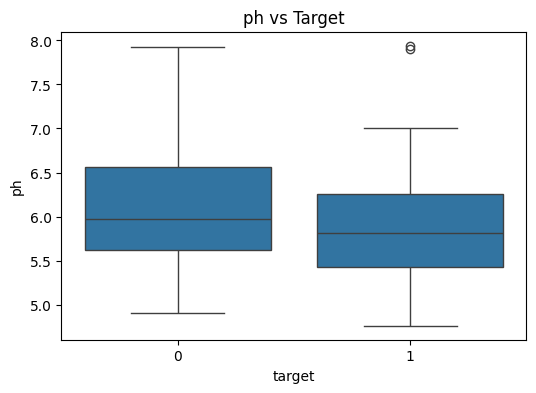

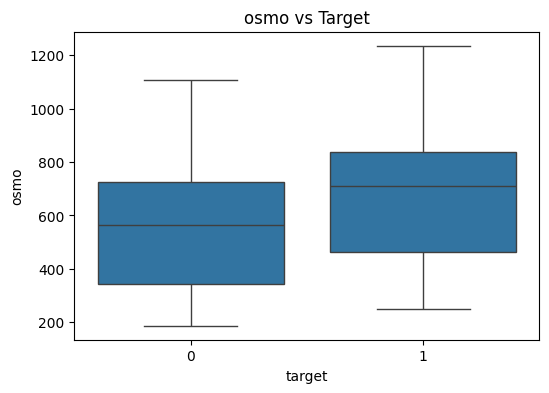

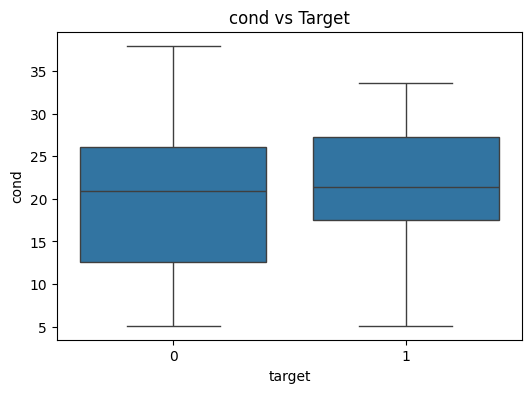

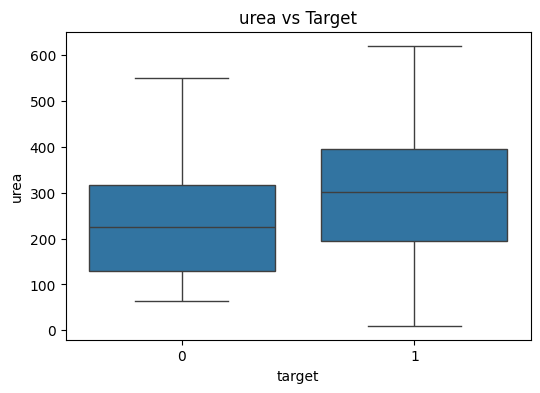

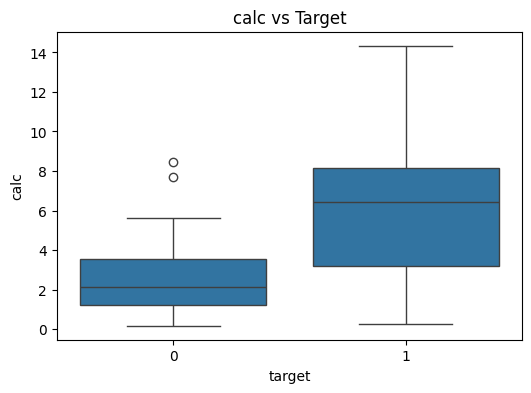

In [27]:
#Feature Relationships with the Target
for col in data.columns[:-1]:  # Excluding the target column
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='target', y=col, data=data)
    plt.title(f"{col} vs Target")
    plt.show()

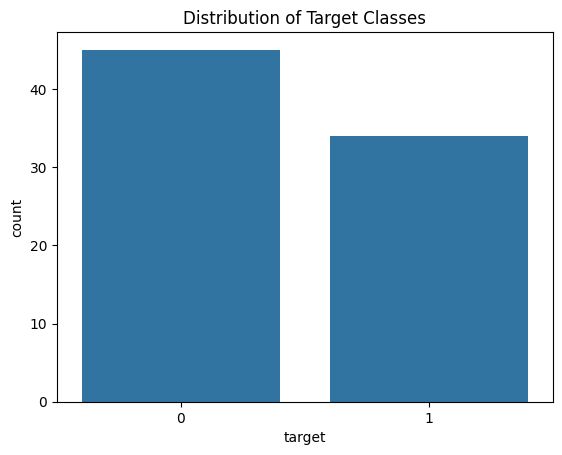

In [29]:
# Plot the target distribution
sns.countplot(x='target', data=data)
plt.title("Distribution of Target Classes")
plt.show()

In [30]:
#above plot indicating the dataset were imbalanced.So i use SMOTE for balance the dataset

In [ ]:
#Feature engineering
# Calculate estimated urine volume
data['urine_volume'] = (1000 * data['gravity'] * data['osmo']) / (18 * 1.001)
# Specific gravity to calcium ratio
data['specific_gravity_calcium_ratio'] = data['gravity'] / data['calc']
# Calcium to conductivity product
data['calcium_conductivity_ratio'] = data['calc'] / data['cond']
# Calcium and pH product
data['calcium_pH_interaction'] = data['calc'] * data['ph']
# Urea and pH product
data['urea_pH_interaction'] = data['urea'] * data['ph']
# Osmolarity and calcium product
data['osmolarity_calcium_interaction'] = data['osmo'] * data['calc']

In [ ]:
# Removing Target variable
X = data.drop('target', axis=1)  
y = data['target']  

In [84]:
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [86]:
#showing accuracy
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred))


Accuracy: 0.6875
Classification Report:               precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.50      0.40      0.44         5

    accuracy                           0.69        16
   macro avg       0.62      0.61      0.61        16
weighted avg       0.67      0.69      0.68        16

Confusion Matrix: [[9 2]
 [3 2]]


In [87]:
#checking feature importance
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance_df)

                           Feature  Importance
8       calcium_conductivity_ratio    0.210649
5                             calc    0.132570
7   specific_gravity_calcium_ratio    0.120558
9           calcium_pH_interaction    0.120128
11  osmolarity_calcium_interaction    0.077485
6                     urine_volume    0.058973
10             urea_pH_interaction    0.056394
0                          gravity    0.050079
4                             urea    0.049154
3                             cond    0.045428
2                             osmo    0.043947
1                               ph    0.034634


In [71]:
num_features = 5  # Choose an appropriate number based on your experimentation
selected_features = feature_importance_df.nlargest(num_features, 'Importance')['Feature'].values

# Create a new DataFrame with only the feature you have selected
X_top = X[selected_features]
print(selected_features)

['calcium_conductivity_ratio' 'calc' 'specific_gravity_calcium_ratio'
 'calcium_pH_interaction' 'osmolarity_calcium_interaction']


In [88]:
# Handling class imbalance
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X[selected_features], y)

# Using SMOTE-resampled data for training
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [78]:
# Prediction Model (Regression)
models = [
    ('LogisticRegression', LogisticRegression(max_iter=10000, random_state=42)),
    ('SVC', SVC(random_state=42)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)),
    ('XGBoost', xgb.XGBClassifier(random_state=42)),
]

In [79]:
# Train and evaluate the models
for name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{name} accuracy: {accuracy:.4f}")

LogisticRegression accuracy: 0.5556
SVC accuracy: 0.6111
RandomForestClassifier accuracy: 0.7222
GradientBoostingClassifier accuracy: 0.6111
XGBoost accuracy: 0.6111


In [108]:
#using stacking classifier for better prediction
lr = LogisticRegression()
svc = SVC(probability=True)
rf = RandomForestClassifier()
gbc = GradientBoostingClassifier()
meta_model = LogisticRegression()

In [109]:
# Define the stacking classifier
stacking_classifier = StackingCVClassifier(
    classifiers=[lr, svc, rf, gbc],
    meta_classifier=meta_model,
    use_probas=True,
    random_state=42
)

In [95]:
# Fit the stacking classifier
best_model=stacking_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_val_pred = best_model.predict(X_val_scaled)

# Calculate the accuracy
stacking_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Stacking Classifier accuracy: {stacking_accuracy:.4f}")

Stacking Classifier accuracy: 0.7222


In [92]:
#Loading the test dataset
test_data = pd.read_csv("C:/Users/GVJai/Desktop/Project/kidney_stone_prediction/test_data.csv")

In [93]:
#Feature engineering
# Calculate estimated urine volume
test_data['urine_volume'] = (1000 * test_data['gravity'] * test_data['osmo']) / (18 * 1.001)
# Specific gravity to calcium ratio
test_data['specific_gravity_calcium_ratio'] = test_data['gravity'] / test_data['calc']
# Calcium to conductivity product
test_data['calcium_conductivity_ratio'] = test_data['calc'] / test_data['cond']
# Calcium and pH product
test_data['calcium_pH_interaction'] = test_data['calc'] * test_data['ph']
# Urea and pH product
test_data['urea_pH_interaction'] = test_data['urea'] * test_data['ph']
# Osmolarity and calcium product
test_data['osmolarity_calcium_interaction'] = test_data['osmo'] * test_data['calc']

In [ ]:
# Preprocessing the test dataset
X_test = test_data[selected_features]

# Scaling the test dataset
X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)

In [ ]:
# Adding predictions to the test DataFrame
test_data['Predicted_test_results'] = y_test_pred

In [ ]:
# Saving the updated test DataFrame with predictions to a new CSV file
test_data.to_csv("C:/Users/GVJai/Desktop/Project/kidney_stone_prediction/Predicted_test_data.csv", index=False)
print("Test data with predictions saved successfully.")

Test data with predictions saved successfully.
